In your project, you will pick a dataset (time-series) and an associated problem that can be
solved via sequence models. You must describe why you need sequence models to solve this
problem. Include a link to the dataset source. Next, you should pick an RNN framework that you
would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other
Python Package). 

I used the famous Amazon Reviews dataset containing millions of Amazon Reviews (http://jmcauley.ucsd.edu/data/amazon/links.html, only the json file of the office supplies reviews). Only sequence models would work on this dataset as its text and it requires positional awareness to predict the sentiment of the review. I only used the first office supplies as my computer could not handle the full amount of the reviews.

In [21]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM, GRU
from tensorflow.keras import Sequential
from typing import List
import matplotlib.pyplot as plt

In [29]:
raw_dataset = ([], [])

with open("reviews.json", "r") as file:
    for line in file.readlines():
        print(line)
        data = json.loads(line)
        raw_dataset[0].append(data["reviewText"])
        raw_dataset[1].append(data["overall"])

In [2]:
# upon inspecting the data it is evident that there are many kinds of punctuation
# we would like a word like "hi!"" to equal tokens of "hi" + "!" rather
# than having "hi" "hi!" be completely different tokens
# such is the case for all other punctuation


# returns to_add_tokens, word without punctuation
punctuation = [",", ".", "!", ":", ";", ")", "]", "(", "["]
def account_for_punct(word):
    to_add_tokens = []
    # check for (, only character that occurs at the beginning
    # others will be at the end

    # if these are the only characters do not check for suffix punctuation
    if word == "[" or word == "(":
        return [punctuation.index(word) + 2], ""

    if "(" == word[0] or "[" == word[0]:
        to_add_tokens.append(punctuation.index("(") + 2)
        word = word[1:]


    # check for end of character punctuation
    end_char = word[-1]
    if end_char in punctuation:
        to_add_tokens.append(punctuation.index(end_char) + 2)
        word = word[:-1]

    return to_add_tokens, word

    

# takes in raw text as array of strings
def get_token_mappings(inpt: List[str]):
    counter = 2 + len(punctuation) # reserved for punctuation
    str_to_token = {"\n" : 0, "": 1} 
    token_to_str = {0: "\n", 1: ""}

    # add the punctuation in
    for i, punct in enumerate(punctuation):
        token_to_str[i + 2] = punct
        str_to_token[punct] = i + 2

    # go line by line and add newline char to end of token input
    tokenized = []
    for line in inpt:
        # remove " character
        line = line.replace('"', "").replace("\n", "").lower()
        # word based tokenization
        words = line.split(" ")

        for word in words:
            # skip token
            if word == "":
                tokenized.append(1)
                continue

            # process punctuation, gets added before word
            # likely not the best strategy but should suffice
            # for this use case
            to_add_tokens, word = account_for_punct(word)
            for token in to_add_tokens:
                tokenized.append(token)

            # add word if not in vocab
            if word not in str_to_token:
                str_to_token[word] = counter
                token_to_str[counter] = word
                counter += 1

            # tokenize processed word
            tokenized.append(str_to_token[word])

        # add newline token
        tokenized.append(0)

    # convert to np array 
    tokenized = np.array(tokenized).reshape(len(tokenized), 1)
    return str_to_token, token_to_str, counter, tokenized

def tokenize(str_to_token, string):
    tokenized = []
    for line in string.split("\n"):
        line = line.replace('"', "").replace("\n", "").lower()
        words = line.split(" ")
        for word in words:
            if word == "":
                tokenized.append(1)
                continue

            to_add_tokens, word = account_for_punct(word)
            for token in to_add_tokens:
                tokenized.append(token)

            tokenized.append(str_to_token[word])

        tokenized.append(0)

    return np.array(tokenized).reshape(len(tokenized), 1)


def lookup(token_to_str, tokens):
    if type(tokens) == np.ndarray:
        tokens = tokens.flatten()

    string = []

    prev_punct = None

    for token in tokens:
        if token == 0:
            string.append("\n")
        elif token == 1:
            string.append("")
        elif token < 2 + len(punctuation):
            punct = punctuation[token - 2]
            if not prev_punct:
                prev_punct = punct
            else:
                if type(prev_punct) == list:
                    prev_punct = prev_punct[0]
                    
                prev_punct = [prev_punct, punct]
        else:
            word = token_to_str[token]
            if prev_punct:
                if type(prev_punct) == list:
                    word = prev_punct[0] + word + prev_punct[1]
                elif prev_punct == "[" or prev_punct == "(":
                    word = prev_punct + word
                else:
                    word = word + prev_punct

                prev_punct = None
            string.append(word)

    return " ".join(string)
            

with open("alllines.txt") as file:
    data = file.readlines()
data = data[:10000]

str_to_token, token_to_str, n_tokens, tokenized = get_token_mappings(data)
print(f"number of unique tokens: {n_tokens}")
random_line_number = int(np.random.rand() * len(data))
random_line = data[random_line_number].replace('"', "").replace("\n", "").lower()
print(f"random line of data: '{random_line}'")
print(f"tokenized version: {list(tokenize(str_to_token, random_line).flatten())}")
reconstructed = lookup(token_to_str, tokenize(str_to_token, random_line)).replace("\n", "")
print(f"reconstructed version from tokens: '{reconstructed}'")

number of unique tokens: 8643
random line of data: 'do me no slander, douglas: by my life,'
tokenized version: [463, 177, 59, 2, 3641, 5, 313, 219, 179, 2, 693, 0]
reconstructed version from tokens: 'do me no slander, douglas: by my life, '


In [3]:
def one_hot_encode_tokens(token_data, n_tokens):
    output = np.zeros((len(token_data), n_tokens))
    for i, token in enumerate(token_data):
        output[i][token] = 1

    return output

def reverse_one_hot_encode(one_hot_encoded):
    tokens = []
    for one_hot in one_hot_encoded:
        tokens.append(np.argmax(one_hot))
    return tokens

In [4]:
split = 0.8
split_index = int(len(tokenized) * split)
data_train = tokenized[:split_index]
data_test = tokenized[split_index:]

data_train = data_train[:-1], one_hot_encode_tokens(data_train[1:], n_tokens) # y is shifted 1 over
data_test = data_test[:-1], one_hot_encode_tokens(data_test[1:], n_tokens)

## Task 1 (60 points):

### Part 1 (30 points): 
Implement your RNN either using an existing framework OR you can
implement your own RNN cell structure. In either case, describe the structure of your
RNN and the activation functions you are using for each time step and in the output
layer. Define a metric you will use to measure the performance of your model (NOTE:
Performance should be measured both for the validation set and the test set).

The metric of the preformance will be crossentropy as we are measuring the likelyhood of tokens appearing after sequences of others. This means that the final activation of the model should also be softamx with a Glorot Unfiform intializer. As described in my last assignment He Uniform is designed to keep the variance of each output 1 for the relu activation function. For nearly all other activations (sigmod like functions such as softmax and tanh) Glorot Unfiform is the initializer to keep the expected output variance at 1. This is important to reduce the chance of exploding / vanishing gradients as especially if we had a deeper neural network we would have an expected variance of $(\sigma^2)^l$ where $l$ is the number of layers, and if $\sigma^2$ is not close to 1 the output would either ballon or deflate rapidly. 

We will also use the ReLU activation function as it has been shown to reduce the vanishing gradient effect that is often seen in RNNs (https://arxiv.org/abs/1511.03771).

The number of hidden units were tuned form random inital values.

The final output size is just the length of one one-hot vector.

In [5]:
units = [64, 64, 128, 512]

model = Sequential([
    Embedding(n_tokens, input_length=1, output_dim=units[0]),
    SimpleRNN(units[1], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    SimpleRNN(units[2], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    SimpleRNN(units[3], activation="relu", kernel_initializer="he_uniform"),
    Dense(n_tokens, activation="softmax", kernel_initializer="glorot_uniform")
])

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy')

2022-10-24 04:59:40.920188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 04:59:40.922522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 04:59:40.922696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 04:59:40.923012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 64)             553152    
                                                                 
 simple_rnn (SimpleRNN)      (None, 1, 64)             8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 128)            24704     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 512)               328192    
                                                                 
 dense (Dense)               (None, 8643)              4433859   
                                                                 
Total params: 5,348,163
Trainable params: 5,348,163
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(*data_train, validation_data=data_test, epochs=22)

2022-10-24 04:59:43.036176: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2758672740 exceeds 10% of free system memory.
2022-10-24 04:59:44.513473: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2758672740 exceeds 10% of free system memory.


Epoch 1/22
  29/2494 [..............................] - ETA: 13s - loss: 8.6348

2022-10-24 04:59:47.624239: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2494/2494 [==============================] - 16s 6ms/step - loss: 5.8900 - val_loss: 5.7249
Epoch 2/22
2494/2494 [==============================] - 13s 5ms/step - loss: 5.3034 - val_loss: 5.7745
Epoch 3/22
2494/2494 [==============================] - 14s 6ms/step - loss: 4.9663 - val_loss: 5.9319
Epoch 4/22
2494/2494 [==============================] - 12s 5ms/step - loss: 4.7265 - val_loss: 6.1444
Epoch 5/22
2494/2494 [==============================] - 12s 5ms/step - loss: 4.5511 - val_loss: 6.2644
Epoch 6/22
2494/2494 [==============================] - 14s 6ms/step - loss: 4.4231 - val_loss: 6.4686
Epoch 7/22
2494/2494 [==============================] - 13s 5ms/step - loss: 4.3242 - val_loss: 6.6172
Epoch 8/22
2494/2494 [==============================] - 13s 5ms/step - loss: 4.2484 - val_loss: 6.8748
Epoch 9/22
2494/2494 [==============================] - 13s 5ms/step - loss: 4.1865 - val_loss: 6.9430
Epoch 10/22
2494/2494 [==============================] - 13s 5ms/step - loss: 4.1377

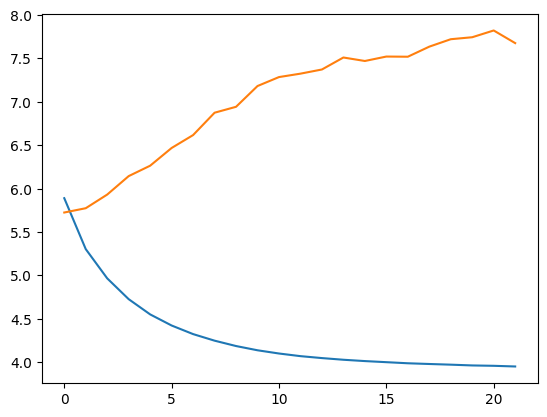

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [8]:
one_hot_pred = model(data_train[0][300:400])
tokens = reverse_one_hot_encode(one_hot_pred)
print("text input:", lookup(token_to_str, data_train[0][300:400].flatten()), "\n\npredicted for each word:")
lookup(token_to_str, tokens)

text input: and bootless 'tis to tell you we will go: 
 therefore we meet not now. then let me hear 
 of you, my gentle cousin westmoreland, 
 what yesternight our council did decree 
 in forwarding this dear expedience. 
 my liege, this haste was hot in question, 
 and many limits of the charge set down 
 but yesternight: when all athwart there came 
 a post from wales loaden with heavy news, 
 whose worst was, that the noble mortimer, 
 leading the men of herefordshire to 

predicted for each word:


"home, ,not, thee \n i, me, me, ,me, \n ,lord, ,lord, \n a, there's \n he, \n the, this a, me \n ,lord, \n i, ,the, lord \n ,very, \n \n ,thee, there's i the there is but ,in, the \n with ,lord, \n ,tidings, lord i, ,lord, \n as, \n ,to,"

I have to do the below step to preserve memory as I will not be able to run the cell after if i do not run this

In [9]:
tf.keras.backend.clear_session()
if model:
    del model

### Part 2 (35 points): 
Update your network from part 1 with first an LSTM and then a GRU
based cell structure (You can treat both as 2 separate implementations). Re-do the
training and performance evaluation. What are the major differences you notice? Why
do you think those differences exist between the 3 implementations (basic RNN, LSTM
and GRU)?
Note: In part 1 and 2, you must perform sufficient data-visualization, pre-processing
and/or feature-engineering if needed. The overall performance visualization of the loss
function should also be provided.


#### LSTM

In [10]:
units = [64, 64, 128, 512]

model = Sequential([
    Embedding(n_tokens, output_dim=units[0]),
    LSTM(units[1], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    LSTM(units[2], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    LSTM(units[3], activation="relu", kernel_initializer="he_uniform"),
    Dense(n_tokens, activation="softmax", kernel_initializer="glorot_uniform")
])

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          553152    
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         98816     
                                                                 
 lstm_2 (LSTM)               (None, 512)               1312768   
                                                                 
 dense (Dense)               (None, 8643)              4433859   
                                                                 
Total params: 6,431,619
Trainable params: 6,431,619
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(*data_train, validation_data=data_test, epochs=22)

2022-10-24 05:04:46.340986: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2758672740 exceeds 10% of free system memory.
2022-10-24 05:04:47.754221: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2758672740 exceeds 10% of free system memory.


Epoch 1/22
2494/2494 [==============================] - 20s 7ms/step - loss: 6.0909 - val_loss: 5.8989
Epoch 2/22
2494/2494 [==============================] - 17s 7ms/step - loss: 5.6726 - val_loss: 5.8748
Epoch 3/22
2494/2494 [==============================] - 17s 7ms/step - loss: 5.4041 - val_loss: 5.8993
Epoch 4/22
2494/2494 [==============================] - 17s 7ms/step - loss: 5.2058 - val_loss: 5.9560
Epoch 5/22
2494/2494 [==============================] - 17s 7ms/step - loss: 5.0524 - val_loss: 6.0540
Epoch 6/22
2494/2494 [==============================] - 17s 7ms/step - loss: 4.9165 - val_loss: 6.1566
Epoch 7/22
2494/2494 [==============================] - 20s 8ms/step - loss: 4.7898 - val_loss: 6.2943
Epoch 8/22
2494/2494 [==============================] - 18s 7ms/step - loss: 4.6799 - val_loss: 6.4323
Epoch 9/22
2494/2494 [==============================] - 20s 8ms/step - loss: 4.5912 - val_loss: 6.5256
Epoch 10/22
2494/2494 [==============================] - 19s 8ms/step - l

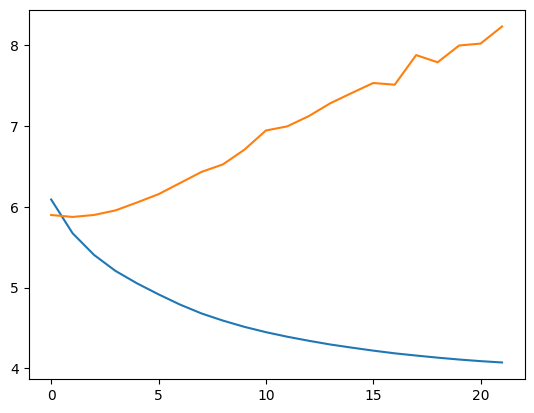

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [13]:
one_hot_pred = model(data_train[0][300:400])
tokens = reverse_one_hot_encode(one_hot_pred)
print("text input:", lookup(token_to_str, data_train[0][300:400].flatten()), "\n\npredicted for each word:")
lookup(token_to_str, tokens)

text input: and bootless 'tis to tell you we will go: 
 therefore we meet not now. then let me hear 
 of you, my gentle cousin westmoreland, 
 what yesternight our council did decree 
 in forwarding this dear expedience. 
 my liege, this haste was hot in question, 
 and many limits of the charge set down 
 but yesternight: when all athwart there came 
 a post from wales loaden with heavy news, 
 whose worst was, that the noble mortimer, 
 leading the men of herefordshire to 

predicted for each word:


"home, the, ,will, not me \n ,will, \n me, \n \n me \n ,lord, ,lord, \n a, there's \n he, \n the, this ,me, \n ,lord, \n \n ,the, lord to ,of, \n ,me, there's i the there is \n \n ,the, \n with the lord, \n countenance, this lord i, ,lord, \n as, \n ,to, the"

In [14]:
tf.keras.backend.clear_session()
if model:
    del model

#### GRU

In [15]:
units = [64, 64, 128, 512]

model = Sequential([
    Embedding(n_tokens, output_dim=units[0]),
    GRU(units[1], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    GRU(units[2], activation="relu", kernel_initializer="he_uniform", return_sequences=True),
    GRU(units[3], activation="relu", kernel_initializer="he_uniform"),
    Dense(n_tokens, activation="softmax", kernel_initializer="glorot_uniform")
])

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          553152    
                                                                 
 gru (GRU)                   (None, None, 64)          24960     
                                                                 
 gru_1 (GRU)                 (None, None, 128)         74496     
                                                                 
 gru_2 (GRU)                 (None, 512)               986112    
                                                                 
 dense (Dense)               (None, 8643)              4433859   
                                                                 
Total params: 6,072,579
Trainable params: 6,072,579
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(*data_train, validation_data=data_test, epochs=22)

2022-10-24 05:11:42.465291: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2758672740 exceeds 10% of free system memory.


Epoch 1/22
2494/2494 [==============================] - 23s 8ms/step - loss: 5.9769 - val_loss: 5.8151
Epoch 2/22
2494/2494 [==============================] - 20s 8ms/step - loss: 5.4701 - val_loss: 5.7730
Epoch 3/22
2494/2494 [==============================] - 20s 8ms/step - loss: 5.1901 - val_loss: 5.9101
Epoch 4/22
2494/2494 [==============================] - 20s 8ms/step - loss: 4.9895 - val_loss: 5.9915
Epoch 5/22
2494/2494 [==============================] - 20s 8ms/step - loss: 4.8111 - val_loss: 6.0650
Epoch 6/22
2494/2494 [==============================] - 20s 8ms/step - loss: 4.6647 - val_loss: 6.2550
Epoch 7/22
2494/2494 [==============================] - 20s 8ms/step - loss: 4.5457 - val_loss: 6.4193
Epoch 8/22
2494/2494 [==============================] - 21s 8ms/step - loss: 4.4474 - val_loss: 6.5761
Epoch 9/22
2494/2494 [==============================] - 20s 8ms/step - loss: 4.3680 - val_loss: 6.7929
Epoch 10/22
2494/2494 [==============================] - 20s 8ms/step - l

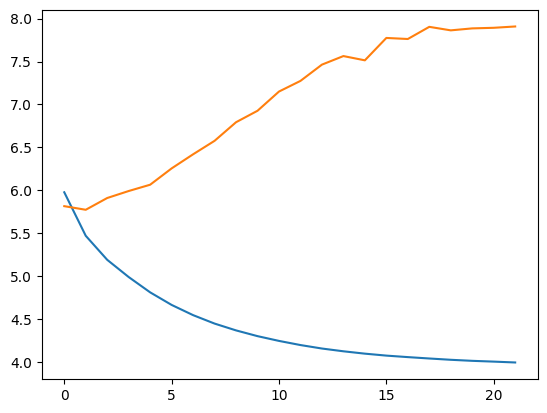

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [18]:
one_hot_pred = model(data_train[0][300:400])
tokens = reverse_one_hot_encode(one_hot_pred)
print("text input:", lookup(token_to_str, data_train[0][300:400].flatten()), "\n\npredicted for each word:")
lookup(token_to_str, tokens)

text input: and bootless 'tis to tell you we will go: 
 therefore we meet not now. then let me hear 
 of you, my gentle cousin westmoreland, 
 what yesternight our council did decree 
 in forwarding this dear expedience. 
 my liege, this haste was hot in question, 
 and many limits of the charge set down 
 but yesternight: when all athwart there came 
 a post from wales loaden with heavy news, 
 whose worst was, that the noble mortimer, 
 leading the men of herefordshire to 

predicted for each word:


"'tis, ,be, thee \n \n ,me, ,me, \n ,lord, ,lord, \n ,there's, \n \n ,the, this a, me \n ,lord, \n i, \n the, lord to ,a, very \n ,thee, there's i the there is \n \n ,the, \n with the music lord \n glory, wearing lord i, ,lord, \n the, \n ,to,"

### Part 3 (10 points): 
Can you use the traditional feed-forward network to solve the same
problem. Why or why not? (Hint: Can time series data be converted to usual features
that can be used as input to a feed-forward network?)

It would not be a complete solution but it would be possible to pass a window of the input, however, this would be memory intensive and would still not capture the full context of the input as any context outside of the window is lost to the model. Another solution would be to pass in an input representing an embedding of the history of the data and outputting the next corresspoding history, but this seems like it would likely count as cheating.

## Task 2 (25 points):

In this task, use any of the pre-trained word embeddings. The Wor2vec embedding link
provided with the lecture notes can be useful to get started. Write your own code/function that 
uses these embeddings and outputs cosine similarity and a dissimilarity score for any 2 pair of
words (read as user input). The dissimilarity score should be defined by you. You either can
have your own idea of a dissimilarity score or refer to literature (cite the paper you used). In
either case clearly describe how this score helps determine the dissimilarity between 2 words.

Note: Dissimilarity measure has been an important metric for recommender systems trying to
introduce ‘Novelty and Diversity’ in assortments (as opposed to only accuracy). You might find
different metrics of dissimilarity in recommender system’s literature.

In [19]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

corpus = api.load('text8')
model = Word2Vec(corpus)

def cosine_sim(a, b):
    return a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

# similarity and distance metrics are inverses of each other
# this is usually a multiplicative relationship
# ie. cosine distance would be 1 / cosine similarity
# therefore distances are the same as dissimilarity
# one very general distance metric is the minkowski distance
# this is a generalization of the euclidian, manhattan 
# and chebyshev distances
# this is just based on ideas behind dissimilarity and
# common distance functions
# p = 1,   manhattan
# p = 2,   euclidian
# p = inf, chebyshev
def minkowski(a, b, p):
    return np.power(np.sum(np.power(np.abs(a - b), p)), 1/p)

In [20]:
def get_sim(a, b):
    # word1 = input("enter the first word: ")
    word1 = a
    print(f"the first word is '{word1}'")

    # word2 = input("enter the second word: ")
    word2 = b
    print(f"the first word is '{word2}'")

    vec1, vec2 = model.wv[word1], model.wv[word2]

    print(f"cosine similarity = {cosine_sim(vec1, vec2)}")
    print(f"manhattan distance = {minkowski(vec1, vec2, 1)}")
    print(f"euclidan distance = {minkowski(vec1, vec2, 2)}")

get_sim("italy", "france")
print("\n")
get_sim("italy", "dog")

the first word is 'italy'
the first word is 'france'
cosine similarity = 0.7851549386978149
manhattan distance = 70.46715545654297
euclidan distance = 8.791315683406694


the first word is 'italy'
the first word is 'dog'
cosine similarity = -0.09008685499429703
manhattan distance = 151.10006713867188
euclidan distance = 18.453127480683577
